In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

In [2]:
# Import the relevant modules
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.control.networks.feature_extractors as fe
import sousvide.utilities.feature_utilities as fu
import figs.visualize.generate_videos as gv
import figs.utilities.transform_helper as th
from sklearn.decomposition import PCA

/home/admin/anaconda3/envs/kitchen/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
cohort = "features"
data_method = "eval_single"
scene = "workshop"
courses = ["button_arc"]

In [4]:
# Generate Rollouts
rg.generate_rollout_data(cohort,courses,scene,data_method)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/workshop/splatfacto/2025-05-07_142842/nerfstudio_models/step-000029999.ckpt

Output()

 button_arc - Ideal Time Steps: [0.    2.679 5.359]

In [13]:
# Load variables
Tro,Xro,Uro,Iro = fu.extract_rollout_data(cohort,courses[0])
pca = PCA(n_components=3)

vit = fe.DINOv2()
Nro = Uro.shape[0]
Ynn,Cls = [],[]
for i in range(Nro):
    img_in = fu.process_image(Iro[i])
    ynn,cls = vit(img_in)

    Ynn.append(ynn)
    Cls.append(cls)

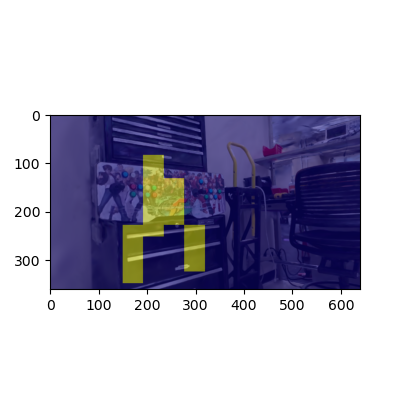

In [16]:
# Static Target on Live V
idx_rf = 10
threshold = 0.90
alpha = 0.2

heat_ref = torch.zeros((16,16))
heat_ref[14, 4] = heat_ref[13, 4] = heat_ref[12, 4] = heat_ref[11, 4] = 1
heat_ref[10, 4] = heat_ref[10, 5] = heat_ref[ 9, 5] = heat_ref[ 8, 5] = 1
heat_ref[13, 7] = heat_ref[12, 7] = heat_ref[11, 7] = heat_ref[10, 7] = 1
heat_ref[ 9, 6] = heat_ref[ 8, 6] = heat_ref[ 7, 6] = heat_ref[ 6, 6] = 1
heat_ref[ 7, 5] = heat_ref[ 6, 5] = heat_ref[ 5, 5] = heat_ref[ 4, 5] = 1

fig,axs = plt.subplots(1, 1, figsize=(4, 4))
overlay = fu.heatmap_overlay(heat_ref,Iro[idx_rf],threshold=threshold)
axs.imshow(overlay)
heat_ref = heat_ref.flatten()

# indices = (heat_ref > 0).nonzero(as_tuple=True)[0]
# targ_dn = Ynn[idx_rf][indices]
# targ_dn = torch.mean(targ_dn,dim=0)
# Hmap_dn = np.zeros((Nro,16,16,3),dtype=np.uint8)
# for i in range(Nro):
#     ynn = Ynn[i]

#     # Compute similiarities
#     rel = torch.matmul(ynn,targ_dn)
#     rel = (rel_dn - torch.min(rel_dn)) / (torch.max(rel_dn) - torch.min(rel_dn))

#     # Generate heatmap
#     rel_dn = rel_dn.reshape(16,16)
#     Hmap_dn[i,:,:,:] = fu.heatmap_overlay(rel_dn,Iro[i],threshold=threshold)

# gv.images_to_mp4(Hmap_dn, "output.mp4", fps=20)

In [ ]:
Nro = Iro.shape[0]
height = Iro.shape[1]
width = Iro.shape[2]

Iout = np.zeros((Nro,height,width,3),dtype=np.uint8)
for p in range(Nro):
    img2 = 1*Iro[p]

    img_in2 = fu.process_image(img2).unsqueeze(0)        
    with torch.no_grad():
        ptk2 = vit(img_in2).squeeze(0).view(16,16,-1)

    cos_sims = torch.zeros((Np,16,16))
    for i in range(Np):
        for j in range(16):
            for k in range(16):
                patch2 = ptk2[j,k,:]
                cos_sims[i,j,k] = F.cosine_similarity(patches[i],patch2,dim=0)

    imgs2_hots = np.zeros((16,16))
    for i in range(Np):
        # max_idx = torch.argmax(cos_sims[i,:,:])
        # row,col = divmod(max_idx.item(), 16)

        # imgs2_hots[row,col] = 1
        imgs2_hots = (cos_sims[i,:,:] > 0.6).float()

        
    Iout[p,:,:,:] = fu.overlay_heatmap_on_image(imgs2_hots,img2)

gv.images_to_mp4(Iout,"output4.mp4",fps=20)